<a href="https://colab.research.google.com/github/SnigdhaBairi/personal/blob/main/Brain%20Tumour%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
Root = "/content/drive/MyDrive/brain_tumor_dataset"
os.chdir(Root)

In [8]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2

In [11]:
data = '/content/drive/MyDrive/brain_tumor_dataset'
No_brain_tumor = '/content/drive/MyDrive/brain_tumor_dataset/no'
Yes_brain_tumor = '/content/drive/MyDrive/brain_tumor_dataset/yes'

In [12]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [13]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/drive/MyDrive/brain_tumor_dataset/no/...,No
1,/content/drive/MyDrive/brain_tumor_dataset/no/...,No
2,/content/drive/MyDrive/brain_tumor_dataset/no/...,No
3,/content/drive/MyDrive/brain_tumor_dataset/no/...,No
4,/content/drive/MyDrive/brain_tumor_dataset/no/...,No


In [14]:
print(df['labels'].value_counts())

Yes    155
No      98
Name: labels, dtype: int64


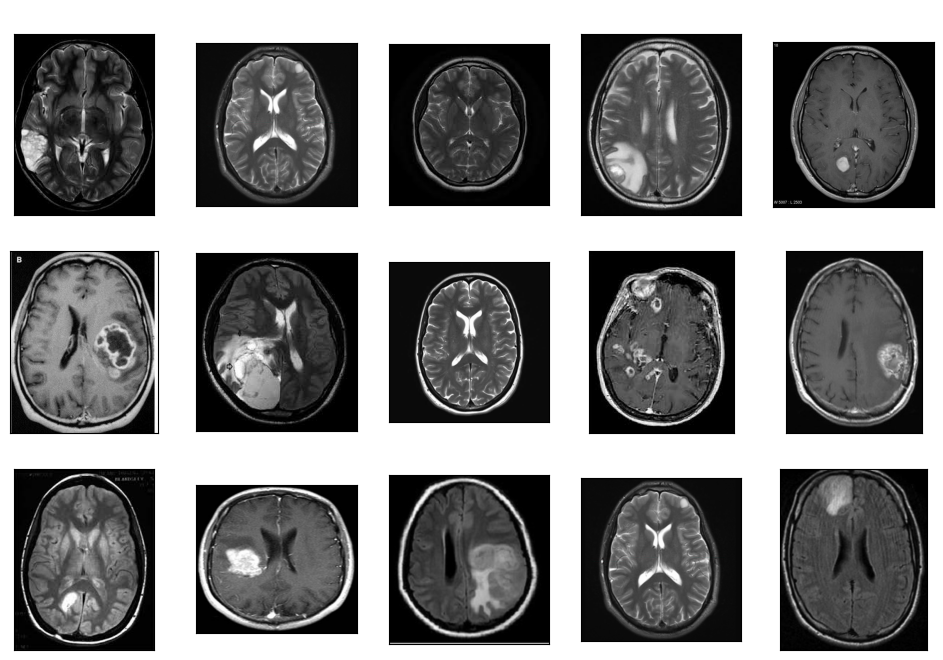

In [15]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white")
    plt.xticks([])
    plt.yticks([])

plt.show()

In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (216, 2)
test set shape: (13, 2)
validation set shape: (24, 2)


In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [18]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32,
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid,
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels',
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 216 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [19]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [20]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23566849 (89.90 MB)
Trainable params: 2049 (8.00

In [21]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 100,
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 1.0913 - accuracy: 0.4306

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 61s 7s/step - loss: 1.0913 - accuracy: 0.4306 - val_loss: 0.7527 - val_accuracy: 0.5833
Epoch 2/100
7/7 [==============================] - 60s 9s/step - loss: 0.9675 - accuracy: 0.4491 - val_loss: 0.7356 - val_accuracy: 0.5417
Epoch 3/100
7/7 [==============================] - 48s 7s/step - loss: 0.9302 - accuracy: 0.4213 - val_loss: 0.6027 - val_accuracy: 0.6667
Epoch 4/100
7/7 [==============================] - 50s 7s/step - loss: 0.8447 - accuracy: 0.5093 - val_loss: 0.8629 - val_accuracy: 0.4583
Epoch 5/100
7/7 [==============================] - 48s 7s/step - loss: 0.7878 - accuracy: 0.4954 - val_loss: 0.6820 - val_accuracy: 0.6250
Epoch 6/100
7/7 [==============================] - 44s 6s/step - loss: 0.7748 - accuracy: 0.5139 - val_loss: 0.6720 - val_accuracy: 0.7083
Epoch 7/100
7/7 [==============================] - 46s 7s/step - loss: 0.7616 - accuracy: 0.5648 - val_loss: 0.6452 - val_accuracy: 0.6250
Epoch 8/100
7/7 [======================

In [22]:
model.save("/content/drive/MyDrive/brain_tumor_dataset/Tumor_classifier_model.h5")

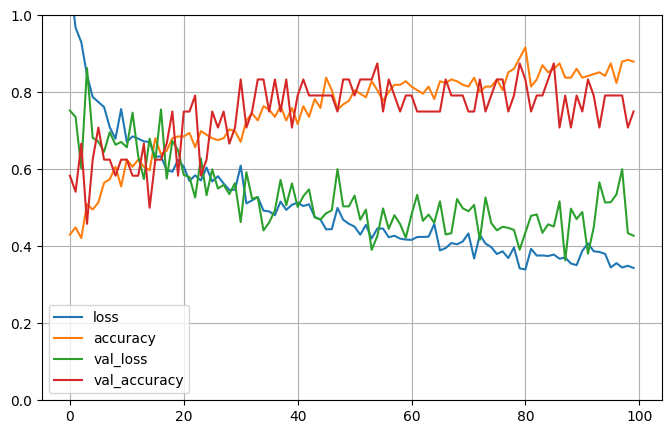

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

1/1 [==============================] - 1s 1s/step


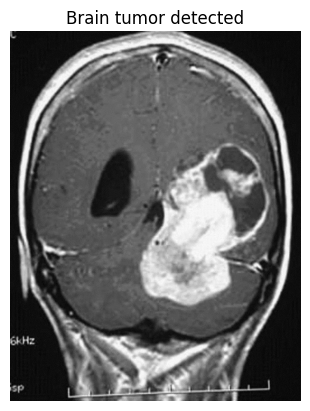

In [26]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the model
model_path = "/content/drive/MyDrive/brain_tumor_dataset/Tumor_classifier_model.h5"
loaded_model = tf.keras.models.load_model(model_path)

# Load and preprocess the image
image = cv2.imread("/content/drive/MyDrive/brain_tumor_dataset/yes/Y104.jpg")
image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image, axis=0)
input_data = np.array(expand_input)
input_data = input_data / 255

# Make prediction
pred = loaded_model.predict(input_data)
result = "No brain tumor detected" if pred[0][0] < 0.5 else "Brain tumor detected"

# Display the image with prediction result
plt.imshow(image)
plt.title(result)
plt.axis('off')
plt.show()


In [27]:
train_gen.class_indices

{'No': 0, 'Yes': 1}